In [1]:
import pandas as pd
from darts import TimeSeries
from darts.models import TCNModel
from darts.metrics import mse, rmse, r2_score, mae, smape, wmape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, facet_grid
)
import json


torch.set_float32_matmul_precision('medium')


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


In [2]:
target_columns = [
    'Temperature', 'Humidity', 'Soil_Moisture', 
    'Soil_Temperature','Precipitation_accumulated'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [3]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [4]:
best_mse = float('inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

# Listas para armazenar dados de todos os folds
all_forecasts = []
all_val_scaled = []
all_scalers = []
all_metrics_dfs = []
all_mse_scores = []
all_train_scaled = []
all_metrics_horizon = []

tscv = TimeSeriesSplit(n_splits=5)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")

    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)


    model = TCNModel(
        model_name=f"model_{fold+1}",
        input_chunk_length=61,
        output_chunk_length=24,
        num_filters=192,
        kernel_size=8,
        num_layers=2,
        dilation_base=3,
        weight_norm=False,
        batch_size=248,
        dropout=0.1,
        add_encoders=encoders,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.L1Loss(),
        optimizer_cls=torch.optim.Adam,
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode": "min", "factor": 0.3, "patience": 7, "min_lr": 1e-7},
        save_checkpoints=True,
        force_reset=True,
        random_state=42,
        optimizer_kwargs={"lr": 0.00023216186910944968, "weight_decay": 0.00811699540802205},
    )
    model.fit(
        series=train_scaled,
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11},
        verbose=False,
    )

    model.load_from_checkpoint(f"model_{fold+1}/", best=True)

    metrics_per_horizon = []
    for i in [1,4,8,12,16,20,24]:
        forecasts = model.historical_forecasts(
            val_scaled,
            forecast_horizon=i,
            stride=1,
            retrain=False,
            verbose=False,
            last_points_only=True,
        )

        forecasts_t = scaler.inverse_transform(forecasts)
        s = scaler.inverse_transform(val_scaled)
        metrics = {}
        print("Iniciando a verificação das séries temporais para constância...")
        try:
            for target in target_columns:
                metrics[target] = {
                    'MSE': mse(s[target], forecasts_t[target]),
                    'RMSE': rmse(s[target], forecasts_t[target]),
                    'MAE': mae(s[target], forecasts_t[target]),
                    'R2': r2_score(s[target], forecasts_t[target]),
                    'SMAPE': smape(s[target], forecasts_t[target]),
                    'WMAPE': wmape(s[target], forecasts_t[target]),
                }
            metrics_df = pd.DataFrame(metrics).T
            print("\nMétricas de performance:")
            print(metrics_df)
            metrics_per_horizon.append(metrics_df)
        except Exception as e:
            print(e)

    mse_geral = mse(s, forecasts_t)
    print(f"O MSE desse fold foi {mse_geral}")

    # Armazenar dados deste fold
    all_forecasts.append(forecasts)
    all_val_scaled.append(val_scaled)
    all_scalers.append(scaler)
    all_metrics_dfs.append(metrics_df)
    all_metrics_horizon.append(metrics_per_horizon)
    all_mse_scores.append(mse_geral)
    all_train_scaled.append(train_scaled)

    # Ainda mantemos o melhor fold para referência (agora baseado no MSE)
    if best_mse > mse_geral:
        best_mse = mse_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold (baseado no menor MSE) foi {best_fold}")

# Calcular a média dos R2 e MSE de todos os folds
avg_mse = sum(all_mse_scores) / len(all_mse_scores)
print(f"A média dos MSE de todos os folds foi {avg_mse:.4f}")

avg_metrics = {}
metric_names = ['MSE', 'RMSE', 'MAE', 'R2', 'SMAPE', 'WMAPE'] # Definir nomes das métricas

for target in target_columns:
    avg_metrics[target] = {} # Inicializar dicionário para o target atual
    for metric_name in metric_names:
        metric_values_for_fold = []
        # Coletar todos os valores válidos da métrica para o target atual em todos os folds
        for df_fold in all_metrics_dfs:
            # Verificar se o target existe como índice e a métrica como coluna no df_fold
            if target in df_fold.index and metric_name in df_fold.columns:
                value = df_fold.loc[target, metric_name]
                # Adicionar à lista apenas se não for NaN
                if pd.notna(value):
                    metric_values_for_fold.append(value)
        
        # Calcular a média apenas se houver valores válidos
        if metric_values_for_fold:
            avg_metrics[target][metric_name] = sum(metric_values_for_fold) / len(metric_values_for_fold)
        else:
            # Caso contrário, registrar NaN (ou outro valor padrão, se preferir)
            avg_metrics[target][metric_name] = float('nan')

avg_metrics_df = pd.DataFrame(avg_metrics).T
print("\nMétricas médias de performance de todos os folds:")
print(avg_metrics_df)


with open('all_metrics_horizon.json', 'w') as f:
    all_metrics_horizon_dict = [
        [df.to_dict() for df in fold_metrics] for fold_metrics in all_metrics_horizon
    ]
    json.dump(all_metrics_horizon_dict, f, indent=4)

# Salvar métricas médias
with open('avg_metrics.json', 'w') as f:
    json.dump(avg_metrics_df.to_dict(), f, indent=4)

print("\nUsando a média dos folds para análise...")

Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Fold 1

Treinando o modelo...
Train set: 1389 samples
Validation set: 1384 samples


Metric val_loss improved. New best score: 12.695
Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 12.678
Metric val_loss improved by 0.451 >= min_delta = 0.001. New best score: 12.227
Metric val_loss improved by 0.043 >= min_delta = 0.001. New best score: 12.184
Metric val_loss improved by 0.238 >= min_delta = 0.001. New best score: 11.947
Metric val_loss improved by 0.334 >= min_delta = 0.001. New best score: 11.612
Metric val_loss improved by 0.118 >= min_delta = 0.001. New best score: 11.494
Metric val_loss improved by 0.120 >= min_delta = 0.001. New best score: 11.374
Metric val_loss improved by 0.147 >= min_delta = 0.001. New best score: 11.227
Metric val_loss improved by 0.077 >= min_delta = 0.001. New best score: 11.151
Metric val_loss improved by 0.130 >= min_delta = 0.001. New best score: 11.021
Metric val_loss improved by 0.061 >= min_delta = 0.001. New best score: 10.960
Metric val_loss improved by 0.060 >= min_delta = 0.001. New best score: 10.900
Met

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE  \
Temperature                4.488365e+05   669.952610   356.397956   
Humidity                   7.922364e+04   281.466938   159.270276   
Soil_Moisture              2.841044e+07  5330.144809  3278.052911   
Soil_Temperature           1.665077e+05   408.053541   218.418394   
Precipitation_accumulated  3.205927e+04   179.051031    98.092825   

                                    R2      SMAPE        WMAPE  
Temperature               -9686.133919  83.848371  2154.550186  
Humidity                   -260.440545  76.148776   209.344490  
Soil_Moisture               -22.080687  61.418978    40.978590  
Soil_Temperature          -2917.266733  81.352734  1331.126516  
Precipitation_accumulated     0.233329  54.091907    71.723669  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE  \
Temperature                4.466300e+05   668.303843   355.953232   
Humidity                   7.893557e+04   280.954750   159.264065   
Soil_Moisture              3.093369e+07  5561.805923  3413.738476   
Soil_Temperature           1.646386e+05   405.756777   217.547094   
Precipitation_accumulated  3.209788e+04   179.158806    98.263070   

                                    R2      SMAPE        WMAPE  
Temperature               -9620.766713  84.005858  2152.728254  
Humidity                   -258.903860  76.443967   209.327182  
Soil_Moisture               -24.121103  61.627218    42.687055  
Soil_Temperature          -2879.367982  81.738118  1326.447378  
Precipitation_accumulated     0.233398  54.187594    71.688472  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE  \
Temperature                4.506252e+05   671.286219   358.086349   
Humidity                   7.974299e+04   282.388020   160.261659   
Soil_Moisture              2.912788e+07  5397.024733  3329.814427   
Soil_Temperature           1.645853e+05   405.691111   217.872705   
Precipitation_accumulated  3.219163e+04   179.420264    98.556722   

                                    R2      SMAPE        WMAPE  
Temperature               -9681.085124  84.337801  2165.389726  
Humidity                   -260.849634  76.710582   210.668443  
Soil_Moisture               -22.641558  61.824747    41.653495  
Soil_Temperature          -2870.493261  82.049458  1328.194183  
Precipitation_accumulated     0.232483  54.360922    71.689146  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE  \
Temperature                4.516381e+05   672.040279   359.027010   
Humidity                   7.973087e+04   282.366554   160.469015   
Soil_Moisture              2.934118e+07  5416.750176  3346.016490   
Soil_Temperature           1.646313e+05   405.747859   218.240023   
Precipitation_accumulated  3.228024e+04   179.667012    98.842305   

                                    R2      SMAPE        WMAPE  
Temperature               -9680.232852  84.493932  2169.774749  
Humidity                   -260.162122  76.886468   211.003755  
Soil_Moisture               -22.799362  62.010032    41.871882  
Soil_Temperature          -2864.513947  82.236360  1329.552727  
Precipitation_accumulated     0.231696  54.512754    71.682670  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE  \
Temperature                4.526156e+05   672.767139   359.955482   
Humidity                   8.063123e+04   283.956395   161.525268   
Soil_Moisture              2.972321e+07  5451.899917  3371.000174   
Soil_Temperature           1.650004e+05   406.202430   218.815395   
Precipitation_accumulated  3.237462e+04   179.929479    99.137624   

                                    R2      SMAPE        WMAPE  
Temperature               -9685.323779  84.625283  2173.538962  
Humidity                   -262.717626  77.096846   212.498107  
Soil_Moisture               -23.088616  62.199234    42.199720  
Soil_Temperature          -2865.482085  82.431644  1331.910293  
Precipitation_accumulated     0.230776  54.666985    71.681971  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE  \
Temperature                4.539324e+05   673.745088   361.022548   
Humidity                   8.097678e+04   284.564187   162.081726   
Soil_Moisture              2.979360e+07  5458.351469  3379.906490   
Soil_Temperature           1.654670e+05   406.776363   219.456069   
Precipitation_accumulated  3.247340e+04   180.203766    99.440717   

                                    R2      SMAPE        WMAPE  
Temperature               -9691.993397  84.815877  2179.108612  
Humidity                   -263.412170  77.302369   213.324558  
Soil_Moisture               -23.119307  62.385691    42.325659  
Soil_Temperature          -2866.707375  82.646594  1335.235663  
Precipitation_accumulated     0.229756  54.827088    71.685569  


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE  \
Temperature                4.553291e+05   674.780747   362.116431   
Humidity                   8.122564e+04   285.001125   162.552299   
Soil_Moisture              2.988510e+07  5466.726928  3389.586204   
Soil_Temperature           1.659759e+05   407.401448   220.109778   
Precipitation_accumulated  3.257332e+04   180.480789    99.746427   

                                    R2      SMAPE        WMAPE  
Temperature               -9743.963008  85.001757  2189.046835  
Humidity                   -263.844598  77.498848   213.860961  
Soil_Moisture               -23.155607  62.569538    42.459601  
Soil_Temperature          -2899.474737  82.823980  1342.452785  
Precipitation_accumulated     0.228716  54.986374    71.689708  
O MSE desse fold foi 6124041.450932215

Fold 2

Treinando o modelo...
Train set: 2773 samples
Validation 

Metric val_loss improved. New best score: 0.271
Metric val_loss improved by 0.083 >= min_delta = 0.001. New best score: 0.188
Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.178
Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.167
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.161
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.155
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.153
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.147
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.143
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.141
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.137
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.135
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.133
Metric val_loss 

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                   23.665397    4.864709    4.080190 -1.949826e+00   
Humidity                      50.342411    7.095239    5.936205 -1.433775e+00   
Soil_Moisture              80523.318414  283.766310  245.144767 -1.338160e+01   
Soil_Temperature              43.038123    6.560345    6.104232 -3.952351e+00   
Precipitation_accumulated  13931.272223  118.030810  106.855124 -2.959720e+06   

                               SMAPE      WMAPE  
Temperature                32.047552  26.250003  
Humidity                    6.759080   6.906152  
Soil_Moisture               3.801522   3.842444  
Soil_Temperature           54.137776  39.234695  
Precipitation_accumulated  20.484343  23.324707  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                   23.424916    4.839929    4.056944 -1.931827e+00   
Humidity                      50.139544    7.080928    5.920528 -1.418919e+00   
Soil_Moisture              79475.814964  281.914553  243.816086 -1.327362e+01   
Soil_Temperature              42.446887    6.515128    6.057950 -3.904333e+00   
Precipitation_accumulated  13958.560697  118.146353  107.033163 -3.165814e+06   

                               SMAPE      WMAPE  
Temperature                31.862428  26.118517  
Humidity                    6.744096   6.888134  
Soil_Moisture               3.782770   3.821429  
Soil_Temperature           53.690662  38.965249  
Precipitation_accumulated  20.517310  23.363528  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                   23.089380    4.805141    4.024727 -1.909005e+00   
Humidity                      49.915470    7.065088    5.908278 -1.401456e+00   
Soil_Moisture              78781.648370  280.680688  242.810533 -1.325344e+01   
Soil_Temperature              42.168639    6.493738    6.036402 -3.899804e+00   
Precipitation_accumulated  13946.821668  118.096662  107.090322 -3.479938e+06   

                               SMAPE      WMAPE  
Temperature                31.566288  25.936601  
Humidity                    6.733570   6.873598  
Soil_Moisture               3.768225   3.805419  
Soil_Temperature           53.481292  38.864356  
Precipitation_accumulated  20.531551  23.375947  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                   22.917895    4.787264    4.006625 -1.905780e+00   
Humidity                      49.814436    7.057934    5.900782 -1.393209e+00   
Soil_Moisture              78446.689802  280.083362  242.309072 -1.330581e+01   
Soil_Temperature              42.004267    6.481070    6.022335 -3.907760e+00   
Precipitation_accumulated  13968.935126  118.190250  107.276479 -3.878730e+06   

                               SMAPE      WMAPE  
Temperature                31.410576  25.844986  
Humidity                    6.726378   6.864082  
Soil_Moisture               3.761121   3.797305  
Soil_Temperature           53.358797  38.811182  
Precipitation_accumulated  20.566910  23.416524  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                   22.785148    4.773379    3.992340 -1.904986e+00   
Humidity                      49.595966    7.042440    5.884559 -1.378151e+00   
Soil_Moisture              77903.335020  279.111689  241.515436 -1.332468e+01   
Soil_Temperature              41.900386    6.473051    6.013192 -3.920764e+00   
Precipitation_accumulated  14006.068791  118.347238  107.520578 -4.390607e+06   

                               SMAPE      WMAPE  
Temperature                31.323844  25.776718  
Humidity                    6.708600   6.844534  
Soil_Moisture               3.749147   3.784610  
Soil_Temperature           53.331499  38.788753  
Precipitation_accumulated  20.611914  23.469749  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                   22.591343    4.753035    3.975843 -1.894673e+00   
Humidity                      49.165638    7.011821    5.860216 -1.353037e+00   
Soil_Moisture              77081.697918  277.635909  240.453844 -1.329872e+01   
Soil_Temperature              41.780306    6.463769    6.003918 -3.930180e+00   
Precipitation_accumulated  14047.224216  118.520986  107.782900 -5.064853e+06   

                               SMAPE      WMAPE  
Temperature                31.230933  25.693245  
Humidity                    6.682129   6.815541  
Soil_Moisture               3.733066   3.767713  
Soil_Temperature           53.316641  38.764649  
Precipitation_accumulated  20.660135  23.526950  


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                   22.376198    4.730349    3.958497 -1.879445e+00   
Humidity                      48.720214    6.979987    5.835428 -1.327670e+00   
Soil_Moisture              76247.157440  276.128878  239.378318 -1.326539e+01   
Soil_Temperature              41.652878    6.453904    5.994330 -3.936921e+00   
Precipitation_accumulated  14089.088835  118.697468  108.049909 -5.990921e+06   

                               SMAPE      WMAPE  
Temperature                31.129539  25.603110  
Humidity                    6.655081   6.785981  
Soil_Moisture               3.716772   3.750603  
Soil_Temperature           53.299204  38.737643  
Precipitation_accumulated  20.709254  23.585174  
O MSE desse fold foi 18089.79911310644

Fold 3

Treinando o modelo...
Train set: 4157 samples
Validation set: 1384 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Metric val_loss improved. New best score: 0.150
Metric val_loss improved by 0.048 >= min_delta = 0.001. New best score: 0.103
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.099
Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.086
Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.078
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.073
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.070
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.066
Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.059
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.053
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.051
Metric val_los

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                    1.434110    1.197543    0.974522    -1.568598   
Humidity                      11.422761    3.379758    2.913031    -0.192173   
Soil_Moisture              46219.526342  214.987270  182.404843    -0.332024   
Soil_Temperature               2.786756    1.669358    1.385272   -13.321691   
Precipitation_accumulated    289.355877   17.010464   10.673281 -7187.076740   

                               SMAPE      WMAPE  
Temperature                11.317548  10.503686  
Humidity                    3.189420   3.198290  
Soil_Moisture               3.062950   3.073883  
Soil_Temperature           15.918308  14.159046  
Precipitation_accumulated   2.398377   2.328242  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                    1.457848    1.207414    0.983162    -1.608150   
Humidity                      11.386929    3.374452    2.908522    -0.189088   
Soil_Moisture              46388.622034  215.380180  182.875045    -0.352267   
Soil_Temperature               2.825009    1.680776    1.397098   -13.524129   
Precipitation_accumulated    288.001659   16.970612   10.646797 -7159.017866   

                               SMAPE      WMAPE  
Temperature                11.431574  10.597701  
Humidity                    3.184684   3.193613  
Soil_Moisture               3.070892   3.082345  
Soil_Temperature           16.064126  14.280376  
Precipitation_accumulated   2.392243   2.322463  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                    1.480286    1.216670    0.992148    -1.655454   
Humidity                      11.347742    3.368641    2.902358    -0.184168   
Soil_Moisture              46608.178685  215.889274  183.474263    -0.379449   
Soil_Temperature               2.859118    1.690893    1.408306   -13.781058   
Precipitation_accumulated    287.569712   16.957881   10.651836 -7155.919766   

                               SMAPE      WMAPE  
Temperature                11.546639  10.698149  
Humidity                    3.178119   3.187133  
Soil_Moisture               3.081037   3.093160  
Soil_Temperature           16.201227  14.398231  
Precipitation_accumulated   2.393217   2.323558  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                    1.485069    1.218634    0.994235    -1.675737   
Humidity                      11.313665    3.363579    2.896724    -0.179369   
Soil_Moisture              46743.480380  216.202406  183.854265    -0.405946   
Soil_Temperature               2.868693    1.693721    1.411810   -13.952849   
Precipitation_accumulated    288.366830   16.981367   10.678365 -7183.663981   

                               SMAPE      WMAPE  
Temperature                11.573480  10.724751  
Humidity                    3.171944   3.181212  
Soil_Moisture               3.087617   3.100297  
Soil_Temperature           16.244155  14.437852  
Precipitation_accumulated   2.399195   2.329342  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                    1.489101    1.220287    0.996011    -1.712489   
Humidity                      11.293445    3.360572    2.892872    -0.175565   
Soil_Moisture              46874.793511  216.505874  184.223144    -0.435191   
Soil_Temperature               2.877567    1.696339    1.415391   -14.249773   
Precipitation_accumulated    289.218200   17.006416   10.707228 -7213.055251   

                               SMAPE      WMAPE  
Temperature                11.597340  10.749406  
Humidity                    3.167710   3.177218  
Soil_Moisture               3.094026   3.107276  
Soil_Temperature           16.287269  14.479417  
Precipitation_accumulated   2.405697   2.335634  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                    1.493164    1.221951    0.998046    -1.756501   
Humidity                      11.292072    3.360368    2.891257    -0.173316   
Soil_Moisture              47009.855936  216.817564  184.627034    -0.466612   
Soil_Temperature               2.886191    1.698879    1.419043   -14.612418   
Precipitation_accumulated    290.096162   17.032210   10.737323 -7243.415190   

                               SMAPE      WMAPE  
Temperature                11.623613  10.777376  
Humidity                    3.165943   3.175657  
Soil_Moisture               3.100991   3.114861  
Soil_Temperature           16.330946  14.522127  
Precipitation_accumulated   2.412474   2.342195  


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                    1.497538    1.223739    1.000381    -1.784802   
Humidity                      11.296035    3.360957    2.890439    -0.171388   
Soil_Moisture              47060.483254  216.934283  184.725742    -0.475166   
Soil_Temperature               2.894813    1.701415    1.422641   -14.827777   
Precipitation_accumulated    290.975926   17.058016   10.764083 -7274.134302   

                               SMAPE      WMAPE  
Temperature                11.652371  10.807406  
Humidity                    3.165044   3.174954  
Soil_Moisture               3.103024   3.116966  
Soil_Temperature           16.373922  14.563083  
Precipitation_accumulated   2.418524   2.348029  
O MSE desse fold foi 9473.429513170766

Fold 4

Treinando o modelo...
Train set: 5541 samples
Validation set: 1384 samples


Metric val_loss improved. New best score: 0.142
Metric val_loss improved by 0.022 >= min_delta = 0.001. New best score: 0.120
Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.109
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.107
Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.098
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.095
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.089
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.089. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                     6.219361    2.493865    2.200832    -0.177779   
Humidity                       93.335560    9.661033    8.817519    -0.108820   
Soil_Moisture              473235.405754  687.921075  446.689415     0.656260   
Soil_Temperature                9.670372    3.109722    2.616099    -0.627901   
Precipitation_accumulated    5818.981581   76.282249   66.963708 -4955.897752   

                               SMAPE      WMAPE  
Temperature                41.147571  39.079111  
Humidity                   10.315086  10.470338  
Soil_Moisture               6.269480   6.828676  
Soil_Temperature           48.993931  47.928826  
Precipitation_accumulated  16.074495  14.555664  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                     6.241774    2.498354    2.205123    -0.182266   
Humidity                       93.180934    9.653027    8.807847    -0.104589   
Soil_Moisture              474559.531197  688.882814  447.736142     0.655700   
Soil_Temperature                9.739290    3.120783    2.628852    -0.642513   
Precipitation_accumulated    5824.222639   76.316595   67.050478 -4968.400784   

                               SMAPE      WMAPE  
Temperature                41.233484  39.192914  
Humidity                   10.305030  10.458299  
Soil_Moisture               6.283782   6.842734  
Soil_Temperature           49.203763  48.228144  
Precipitation_accumulated  16.094562  14.574423  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                     6.248502    2.499700    2.206228    -0.182303   
Humidity                       92.827782    9.634718    8.786388    -0.097248   
Soil_Moisture              475915.060728  689.865973  448.956598     0.655248   
Soil_Temperature                9.793102    3.129393    2.639511    -0.655177   
Precipitation_accumulated    5841.051051   76.426769   67.209266 -4993.745168   

                               SMAPE      WMAPE  
Temperature                41.290697  39.251482  
Humidity                   10.282183  10.432020  
Soil_Moisture               6.300539   6.858763  
Soil_Temperature           49.395266  48.509712  
Precipitation_accumulated  16.133467  14.608801  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                     6.261347    2.502268    2.208585    -0.183033   
Humidity                       92.847465    9.635739    8.784834    -0.094273   
Soil_Moisture              477403.404251  690.943850  450.224137     0.654707   
Soil_Temperature                9.822344    3.134062    2.645139    -0.663500   
Precipitation_accumulated    5859.077516   76.544611   67.388142 -5020.457520   

                               SMAPE      WMAPE  
Temperature                41.361782  39.328672  
Humidity                   10.281006  10.429496  
Soil_Moisture               6.317889   6.875499  
Soil_Temperature           49.519555  48.698639  
Precipitation_accumulated  16.177050  14.647543  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                     6.273453    2.504686    2.210683    -0.183076   
Humidity                       92.849795    9.635860    8.782332    -0.091125   
Soil_Moisture              478875.231585  692.008115  451.479263     0.654191   
Soil_Temperature                9.850250    3.138511    2.650580    -0.671288   
Precipitation_accumulated    5876.922747   76.661090   67.565955 -5047.369570   

                               SMAPE      WMAPE  
Temperature                41.428297  39.395945  
Humidity                   10.278713  10.425764  
Soil_Moisture               6.335045   6.892045  
Soil_Temperature           49.641560  48.883189  
Precipitation_accumulated  16.220349  14.686054  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                     6.280587    2.506110    2.211385    -0.181518   
Humidity                       92.810452    9.633818    8.777720    -0.087665   
Soil_Moisture              480344.428609  693.068848  452.766042     0.653676   
Soil_Temperature                9.876884    3.142751    2.655362    -0.678180   
Precipitation_accumulated    5894.680467   76.776822   67.741375 -5074.570876   

                               SMAPE      WMAPE  
Temperature                41.475429  39.430098  
Humidity                   10.273751  10.419179  
Soil_Moisture               6.352754   6.909036  
Soil_Temperature           49.756271  49.052636  
Precipitation_accumulated  16.263101  14.724042  


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                     6.291903    2.508367    2.213725    -0.185316   
Humidity                       92.780582    9.632268    8.774006    -0.084766   
Soil_Moisture              481811.358011  694.126327  453.990538     0.653163   
Soil_Temperature                9.897647    3.146053    2.658478    -0.684063   
Precipitation_accumulated    5912.434760   76.892358   67.915523 -5102.143739   

                               SMAPE      WMAPE  
Temperature                41.547134  39.521408  
Humidity                   10.269253  10.413244  
Soil_Moisture               6.369342   6.925048  
Soil_Temperature           49.854929  49.191791  
Precipitation_accumulated  16.305573  14.761753  
O MSE desse fold foi 97566.55258071586

Fold 5

Treinando o modelo...
Train set: 6925 samples
Validation set: 1384 samples


Metric val_loss improved. New best score: 0.136
Metric val_loss improved by 0.016 >= min_delta = 0.001. New best score: 0.121
Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.107
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.102
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.096
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.094
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.089
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.086
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.083
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.081
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.079
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.077
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.076
Metric val_loss 

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                   12.695887    3.563129    2.825196     0.545276   
Humidity                      85.726690    9.258871    7.397391     0.451619   
Soil_Moisture              32573.470950  180.481220  146.011132    -4.237154   
Soil_Temperature               7.780490    2.789353    2.393005     0.410003   
Precipitation_accumulated   1669.384729   40.858105   37.071321 -1067.695840   

                               SMAPE      WMAPE  
Temperature                34.346671  28.153277  
Humidity                    8.892031   8.605415  
Soil_Moisture               1.705382   1.685322  
Soil_Temperature           36.711239  27.470520  
Precipitation_accumulated   8.367493   7.969286  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                   12.757415    3.571752    2.832998     0.541113   
Humidity                      85.597994    9.251918    7.390610     0.453283   
Soil_Moisture              32335.434764  179.820563  145.333783    -4.202796   
Soil_Temperature               7.791970    2.791410    2.396280     0.404563   
Precipitation_accumulated   1673.733367   40.911287   37.148957 -1081.419616   

                               SMAPE      WMAPE  
Temperature                34.263988  28.177746  
Humidity                    8.886482   8.597888  
Soil_Moisture               1.697321   1.677464  
Soil_Temperature           36.677160  27.453769  
Precipitation_accumulated   8.385203   7.985861  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                   12.824809    3.581174    2.841518     0.539644   
Humidity                      84.593403    9.197467    7.352100     0.458137   
Soil_Moisture              32154.038184  179.315471  144.784135    -4.191674   
Soil_Temperature               7.831380    2.798460    2.403101     0.398584   
Precipitation_accumulated   1678.535849   40.969938   37.237786 -1099.687191   

                               SMAPE      WMAPE  
Temperature                34.372962  28.244270  
Humidity                    8.836337   8.547991  
Soil_Moisture               1.690731   1.671052  
Soil_Temperature           36.728173  27.477214  
Precipitation_accumulated   8.405410   8.004804  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                   12.877485    3.588521    2.850409     0.539058   
Humidity                      84.307015    9.181885    7.333830     0.457903   
Soil_Moisture              31931.119365  178.692807  144.196863    -4.165609   
Soil_Temperature               7.864292    2.804334    2.410340     0.396243   
Precipitation_accumulated   1682.363785   41.016628   37.305085 -1118.039181   

                               SMAPE      WMAPE  
Temperature                34.484641  28.322196  
Humidity                    8.808249   8.521105  
Soil_Moisture               1.683661   1.664215  
Soil_Temperature           36.839503  27.527232  
Precipitation_accumulated   8.420734   8.019117  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                   12.918163    3.594185    2.856998     0.537339   
Humidity                      84.181237    9.175033    7.322074     0.459095   
Soil_Moisture              31733.230284  178.138234  143.676774    -4.136524   
Soil_Temperature               7.889219    2.808775    2.416077     0.392655   
Precipitation_accumulated   1686.839487   41.071152   37.380383 -1137.588203   

                               SMAPE      WMAPE  
Temperature                34.539409  28.339090  
Humidity                    8.792970   8.504290  
Soil_Moisture               1.677406   1.658163  
Soil_Temperature           36.898449  27.545261  
Precipitation_accumulated   8.437939   8.035148  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                   12.953657    3.599119    2.862119     0.533714   
Humidity                      84.175036    9.174695    7.316160     0.460714   
Soil_Moisture              31572.101598  177.685401  143.226414    -4.109052   
Soil_Temperature               7.912763    2.812963    2.422023     0.386509   
Precipitation_accumulated   1691.719616   41.130519   37.466328 -1158.236455   

                               SMAPE      WMAPE  
Temperature                34.454474  28.316070  
Humidity                    8.787878   8.496754  
Soil_Moisture               1.672000   1.652922  
Soil_Temperature           36.939350  27.550146  
Precipitation_accumulated   8.457540   8.053466  
Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE

In [5]:
# Ainda carregamos o modelo do melhor fold para previsões
model.load_from_checkpoint(f"model_{best_fold}/", best=True)

TCNModel(output_chunk_shift=0, kernel_size=8, num_filters=192, num_layers=2, dilation_base=3, weight_norm=False, dropout=0.1, model_name=model_5, input_chunk_length=61, output_chunk_length=24, batch_size=248, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute'], 'future': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler, 'datetime_attribute': {'past': ['year'], 'future': ['year']}}, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x78daf3d5c050>]}, loss_fn=L1Loss(), optimizer_cls=<class 'torch.optim.adam.Adam'>, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.3, 'patience': 7, 'min_lr': 1e-07}, save_checkpoints=True, force_reset=True, random_state=42, optimizer_kwargs={'lr': 0.00023216186910944968, 'weight_decay': 0.00811699540802205})

In [6]:
# Preparar dados para visualização usando a média dos folds
# Primeiro, vamos transformar os dados de cada fold
all_s_dfs = []
all_forecasts_dfs = []

for i, (val_scaled, forecasts, scaler) in enumerate(zip(all_val_scaled, all_forecasts, all_scalers)):
    # Transformar dados de validação
    s_fold = scaler.inverse_transform(val_scaled)
    s_fold_df = s_fold.to_dataframe()
    s_fold_df = s_fold_df.reset_index()
    s_fold_df['fold'] = i + 1
    all_s_dfs.append(s_fold_df)

    # Transformar previsões
    forecasts_fold = scaler.inverse_transform(forecasts)
    forecasts_fold_df = forecasts_fold.to_dataframe()
    forecasts_fold_df = forecasts_fold_df.reset_index()
    forecasts_fold_df['fold'] = i + 1
    all_forecasts_dfs.append(forecasts_fold_df)

# Combinar todos os dataframes
s_df = pd.concat(all_s_dfs)
forecasts_t_df = pd.concat(all_forecasts_dfs)

# Renomear colunas para consistência
s_df = s_df.rename(columns={"time": "Timestamp"})
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})

# Para referência, também mantemos os dados do melhor fold
s_best = best_scaler.inverse_transform(best_val_scaled)
forecasts_t_best = best_scaler.inverse_transform(best_forecasts)
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Humidity', 'Soil_Moisture',
       'Soil_Temperature', 'Precipitation_accumulated', 'fold'],
      dtype='object', name='component')


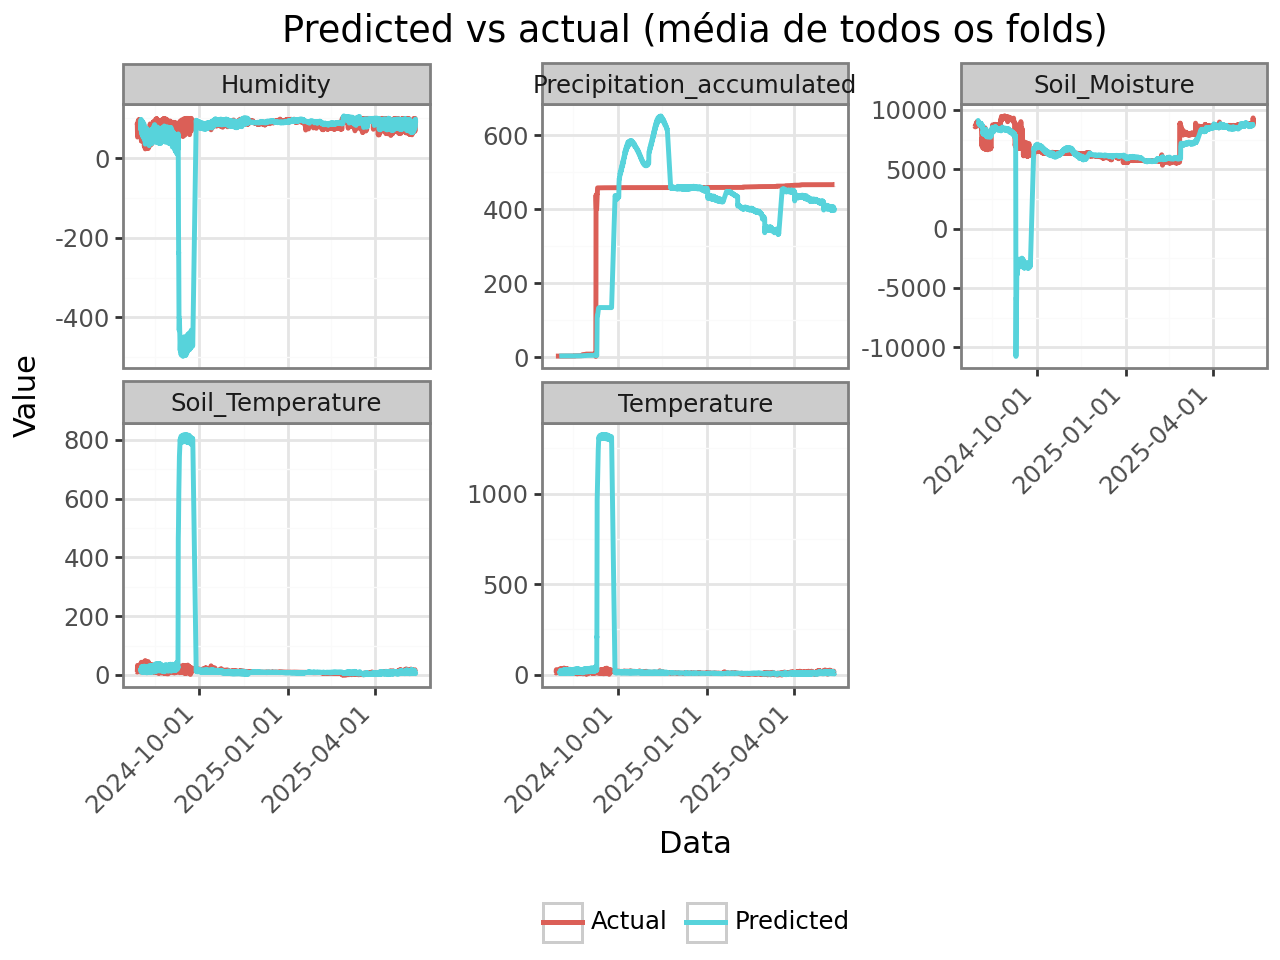

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_avg.png


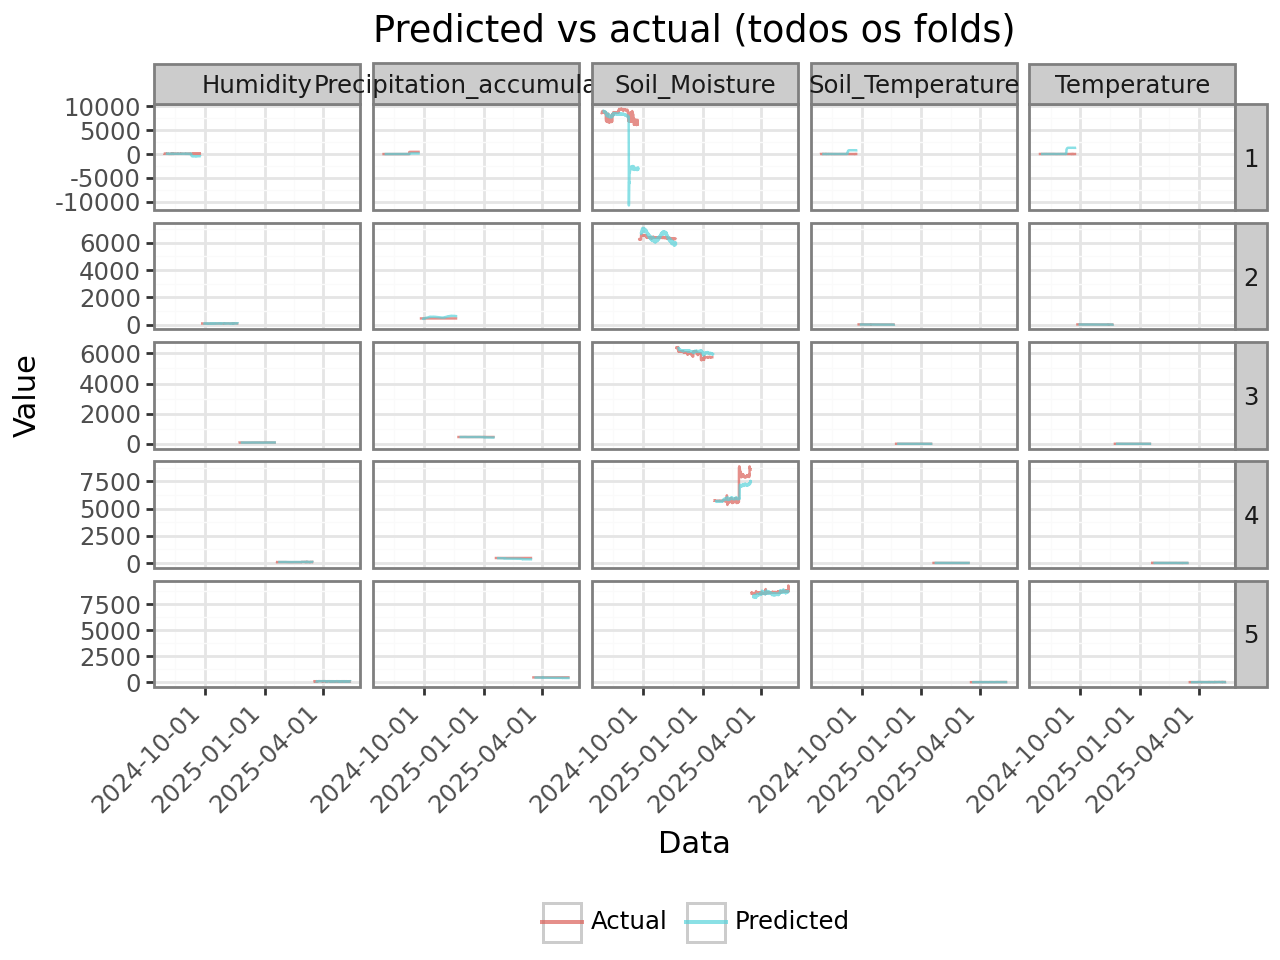

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 15 x 20 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_all_folds.png
/tmp/ipykernel_9340/688565223.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


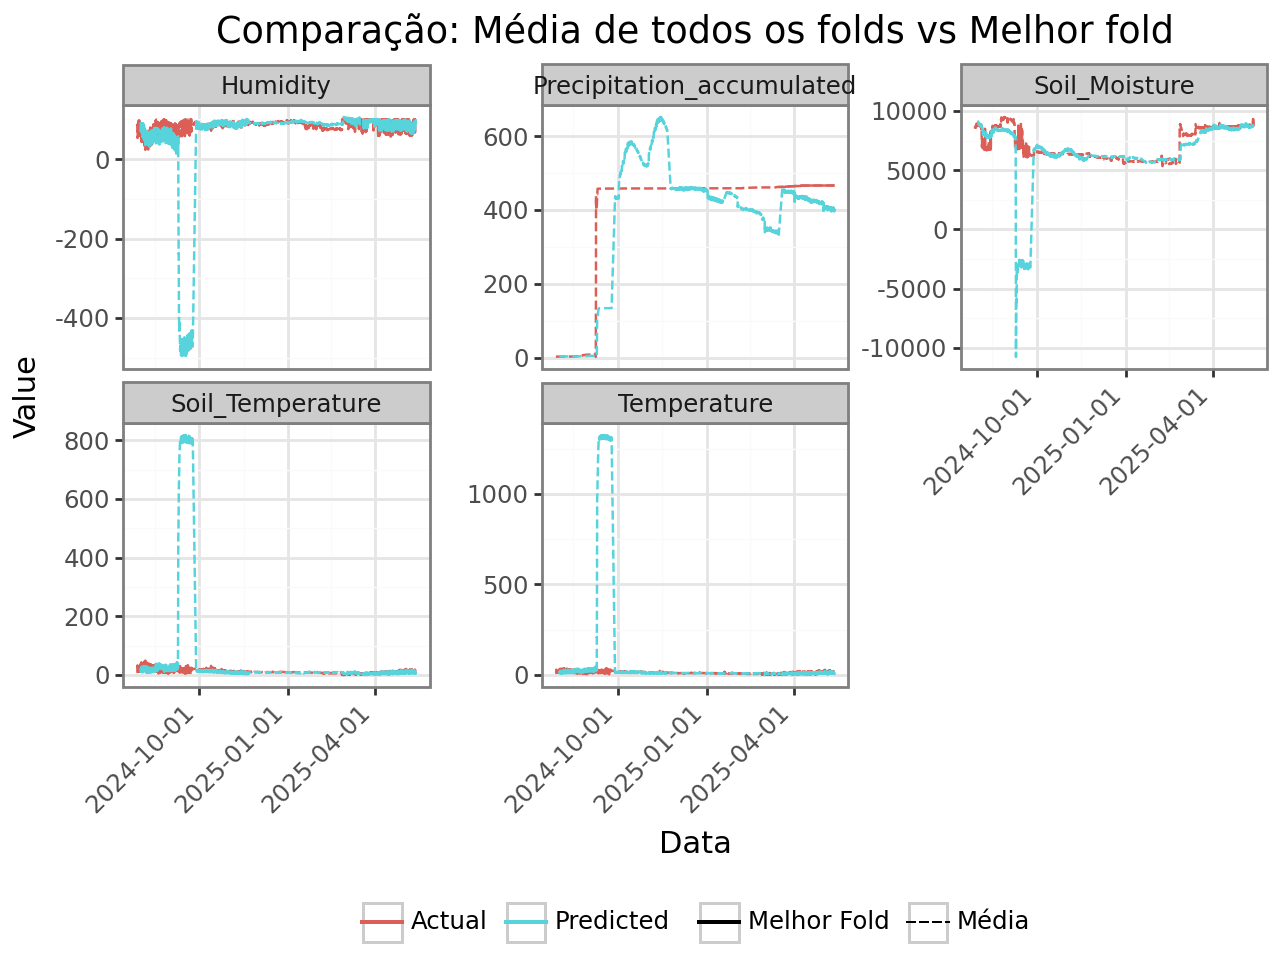

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_comparison.png


In [7]:
plot_columns = ['Timestamp', 'fold'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars=['Timestamp', 'fold'],
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Actual'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars=['Timestamp', 'fold'],
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Predicted'

df_combined = pd.concat([s_melted, forecasts_t_melted])

df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

# Também criar uma versão agregada (média) para cada target e timestamp
df_avg = df_combined.groupby(['Date', 'target_column', 'type']).agg({'value': 'mean'}).reset_index()
df_avg['fold'] = 'Média'

# Combinar os dados médios com os dados originais
df_all = pd.concat([df_combined, df_avg])

# Plot 1: Média de todos os folds
plot_avg = (
    ggplot(df_avg, aes(x='Date', y='value', color='type'))
    + geom_line(size=1)
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual (média de todos os folds)',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot_avg.show()
plot_avg.save('predict_actual_avg.png', width=12, height=10, dpi=300)

# Plot 2: Todos os folds separados por target
plot_all_folds = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line(alpha=0.7)
    + facet_grid('fold ~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual (todos os folds)',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
        strip_text_y=element_text(angle=0)
    )
)
plot_all_folds.show()
plot_all_folds.save('predict_actual_all_folds.png', width=15, height=20, dpi=300)

# Plot 3: Comparação da média com o melhor fold
# Primeiro, preparar os dados do melhor fold
best_fold_data = df_combined[df_combined['fold'] == best_fold]
best_fold_data['fold'] = 'Melhor Fold'
comparison_data = pd.concat([df_avg, best_fold_data])

plot_comparison = (
    ggplot(comparison_data, aes(x='Date', y='value', color='type', linetype='fold'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Comparação: Média de todos os folds vs Melhor fold',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot_comparison.show()
plot_comparison.save('predict_actual_comparison.png', width=12, height=10, dpi=300)

In [8]:
# Salvar métricas do melhor fold
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)

# Salvar métricas médias
with open('avg_metrics.json', 'w') as f:
    json.dump(avg_metrics_df.to_dict(), f, indent=4)

# Salvar todas as métricas em um único arquivo
all_metrics = {
    'average': avg_metrics_df.to_dict(),
    'best_fold': best_metrics.to_dict(),
    'all_folds': {f'fold_{i+1}': df.to_dict() for i, df in enumerate(all_metrics_dfs)}
}
with open('all_metrics.json', 'w') as f:
    json.dump(all_metrics, f, indent=4)

print("\nAnálise completa! Os resultados foram salvos usando a média de todos os folds.")



Análise completa! Os resultados foram salvos usando a média de todos os folds.
